In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.

Primero queremos dejar la variable 'Failure_today' como variable binaria, y botaremos la variable 'Leakage' ya que es redundante con Failure, puesto que uno implica la otra y eso ensuciaria el modelo.

In [2]:
df = pd.read_csv('machine_failure_data.csv')
df['Failure_today'] = df['Failure_today'].apply(lambda x: 0 if x == 'No' else 1)
df = df.drop(columns=['Leakage'])
print(df.describe())


            Location       Min_Temp       Max_Temp   Evaporation  \
count  142193.000000  141556.000000  141871.000000  81350.000000   
mean       24.740655      12.186400      23.226784      5.469824   
std        14.237503       6.403283       7.117618      4.188537   
min         1.000000      -8.500000      -4.800000      0.000000   
25%        12.000000       7.600000      17.900000      2.600000   
50%        25.000000      12.000000      22.600000      4.800000   
75%        37.000000      16.800000      28.200000      7.400000   
max        49.000000      33.900000      48.100000    145.000000   

        Electricity  Parameter1_Speed  Parameter3_9am  Parameter3_3pm  \
count  74377.000000     132923.000000   140845.000000   139563.000000   
mean       7.624853         39.984292       14.001988       18.637576   
std        3.781525         13.588801        8.893337        8.803345   
min        0.000000          6.000000        0.000000        0.000000   
25%        4.900000   

Vemos que existen datos de tarde y de mañana, no nos es util ya que el fallo no se indica cuando si no que dia ocurrión por lo que es mas razonable juntar estas variables promediandolas

In [3]:
for i in [3, 4, 5, 6, 7]:  # Indices correspondientes a los parámetros (4, 6, 5, 7)
    col_9am = f'Parameter{i}_9am'
    col_3pm = f'Parameter{i}_3pm'
    n_col = f'Parameter{i}_prom'
    df[n_col] = df[[col_9am, col_3pm]].mean(axis=1)

df = df.drop(columns=[f'Parameter{i}_9am' for i in [3, 4, 5,6, 7]] + [f'Parameter{i}_3pm' for i in [3, 4, 5, 6, 7]])


In [4]:
print(df.select_dtypes(include='object')[:5])

        Date Parameter1_Dir Parameter2_9am Parameter2_3pm
0  12/1/2008              W              W            WNW
1  12/2/2008            WNW            NNW            WSW
2  12/3/2008            WSW              W            WSW
3  12/4/2008             NE             SE              E
4  12/5/2008              W            ENE             NW


Tenemos direcciones del viento como variabes objeto, podriamos usar dummies en los modelos pero son muchas variables, verificamos su correlación con la variable dependiente parra ver si podemos desistir de estas columnas.  

In [5]:
# Crear dummies
df_dummies = pd.get_dummies(df, columns=['Parameter1_Dir','Parameter2_9am','Parameter2_3pm'])

# Calcular correlación solo con columnas dummies
cols_dummies = [col for col in df_dummies.columns if col.startswith(('Parameter1_Dir','Parameter2_9am','Parameter2_3pm'))]
corr_with_failure = df_dummies[cols_dummies + ['Failure_today']].corr()['Failure_today'].drop('Failure_today').sort_values(ascending=False)

# Mostrar resultados
print("Correlación de dummies de viento con 'Failure_today':\n")
print(corr_with_failure)


Correlación de dummies de viento con 'Failure_today':

Parameter2_9am_WSW    0.072070
Parameter2_9am_SW     0.071875
Parameter2_9am_W      0.062415
Parameter1_Dir_W      0.050023
Parameter2_9am_SSW    0.048806
Parameter2_3pm_SSW    0.046302
Parameter1_Dir_WSW    0.045591
Parameter2_3pm_WSW    0.044476
Parameter2_3pm_W      0.044457
Parameter2_9am_WNW    0.039238
Parameter1_Dir_SW     0.037742
Parameter1_Dir_SSW    0.037648
Parameter2_3pm_SW     0.037201
Parameter2_3pm_S      0.031779
Parameter2_9am_S      0.031064
Parameter1_Dir_S      0.030906
Parameter1_Dir_WNW    0.029638
Parameter2_3pm_WNW    0.028858
Parameter2_9am_NW     0.019411
Parameter2_9am_NNW    0.016093
Parameter2_3pm_SSE    0.011446
Parameter1_Dir_SSE    0.003887
Parameter1_Dir_NW     0.003293
Parameter2_3pm_NW    -0.000914
Parameter2_9am_SSE   -0.002887
Parameter2_3pm_SE    -0.004196
Parameter1_Dir_SE    -0.013849
Parameter1_Dir_NNW   -0.015687
Parameter2_3pm_NNW   -0.026125
Parameter1_Dir_ESE   -0.027675
Parameter2_9am_

En efecto ninguna supera el 0.1 en correlación por lo que podemos desistir de ella y hacer menos engorroso el modelo sin perder mucha significancia. 

In [6]:
df = df.drop(columns=['Parameter1_Dir','Parameter2_9am','Parameter2_3pm'])

In [7]:
corr = df.drop(columns=['Date']).corr()
corr_conciderables = corr.where(np.tril(corr.abs(), k=-1) >= 0.5).stack()
corr_conciderables

Max_Temp         Min_Temp            0.736267
Evaporation      Max_Temp            0.588915
Parameter3_prom  Parameter1_Speed    0.739849
Parameter4_prom  Max_Temp           -0.547021
                 Electricity        -0.612292
Parameter6_prom  Electricity        -0.760263
                 Parameter4_prom     0.543561
Parameter7_prom  Min_Temp            0.831536
                 Max_Temp            0.969906
                 Evaporation         0.578824
dtype: float64

Aquí buscamos correlaciones ya que la variable Evaporation, Electricity y Parametro 6 tienen muchas mediciones vacias al rededor de un 30%, por lo que usar un dropna no es ideal, mejor buscamos su mejor correlacion con otra variable y las juntamos. 

In [8]:
df['Electricity_neg'] = -df['Electricity']
df['Electricity_prom'] = df[['Parameter4_prom', 'Electricity_neg']].apply(lambda x: x.mean(skipna=True), axis=1)
df = df.drop(columns=['Parameter4_prom', 'Electricity'])

df['Evaporation_prom'] = df[['Parameter7_prom', 'Evaporation']].mean(axis=1)
df = df.drop(columns=['Parameter7_prom', 'Evaporation', 'Electricity_neg'])

df = df.drop(columns=['Parameter6_prom'])

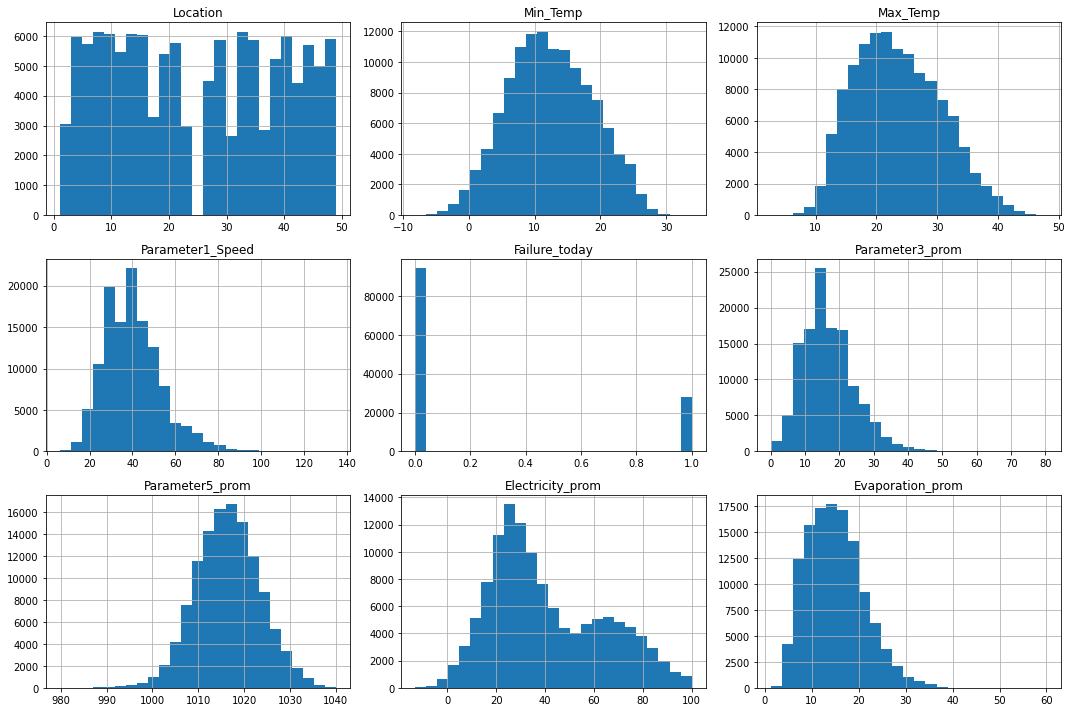

In [9]:
df.dropna(inplace=True)

df.drop(columns=['Date']).iloc[:, :].hist(figsize=(15, 10), bins=25)
plt.tight_layout()
plt.show()


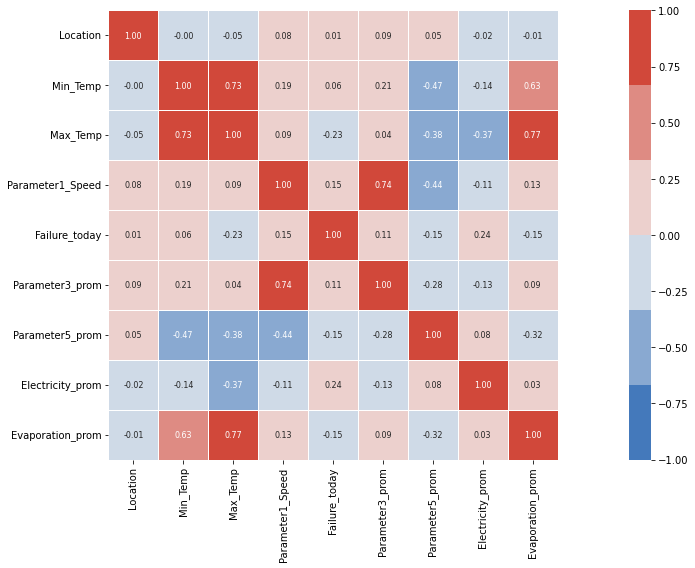

In [10]:
# Graficar el mapa de calor
corr = df.drop(columns=['Date']).corr()
f, ax = plt.subplots(figsize = (20,8))
cmap = sns.diverging_palette(250, 15)
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, annot=True, annot_kws={'size': 8}, fmt='.2f', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()


2. Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [11]:
X = df.drop(columns=['Failure_today','Location','Date'])
X = sm.add_constant(X)
y = df['Failure_today']

model = (sm.OLS(y, X)).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     4689.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:21:16   Log-Likelihood:                -52680.
No. Observations:              122176   AIC:                         1.054e+05
Df Residuals:                  122168   BIC:                         1.055e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.1526      0.198  

El modelo de regresión OLS tiene un R-cuadrado de 0.212, lo que indica que explica solo el 21.2% de la variabilidad de Failure_today. Sin embargo, el modelo es altamente significativo, ya que todos los coeficientes son estadísticamente significativos con valores p cercanos a 0.00. Las variables independientes como la temperatura mínima, la velocidad, y la evaporación tienen relaciones negativas o positivas con Failure_today, dependiendo del coeficiente. Aunque el modelo es significativo, su capacidad explicativa es limitada, y el alto número de condición sugiere posibles problemas de multicolinealidad entre las variables independientes. Además, los residuos no son normales, lo que podría afectar la validez de las inferencias.

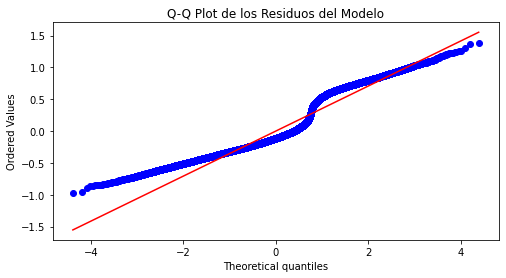

{'Valor de LM': 21666.52834210152, 'valor-p LM': 0.0, 'Valor de F': 3762.1989973914915, 'valor-p F': 0.0}
Estadístico de Shapiro-Wilk: 0.9003207087516785
Valor-p: 0.0


In [12]:
from statsmodels.stats.diagnostic  import  het_breuschpagan
residuos = model.resid; 
bp_test = het_breuschpagan (residuos, X); 
etiquetas = ['Valor de LM', 'valor-p LM', 'Valor de F', 'valor-p F']; 
plt.figure(figsize=(8, 4)) 
stats.probplot(model.resid, dist="norm", plot=plt); 
plt.title('Q-Q Plot de los Residuos del Modelo'); 
plt.show() 
shapiro_test= stats.shapiro (model.resid) 
print(dict(zip (etiquetas, bp_test))); 
print (f"Estadístico de Shapiro-Wilk: {shapiro_test [0]}") 
print (f"Valor-p: {shapiro_test[1]}")

El modelo es globalmente significativo (valor-p F = 0.0), pero presenta problemas en los residuos. El test de Lagrange Multiplier (LM) indica autocorrelación en los residuos, lo que podría afectar la independencia de los errores. Además, el test de Shapiro-Wilk muestra que los residuos no siguen una distribución normal, lo que podría afectar la validez de las inferencias del modelo. En resumen, aunque el modelo es significativo, se deben abordar los problemas de autocorrelación y la no normalidad de los residuos.

3. Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [13]:
model = sm.Probit(y, X)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.413881
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               122176
Model:                         Probit   Df Residuals:                   122168
Method:                           MLE   Df Model:                            7
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.2289
Time:                        00:21:17   Log-Likelihood:                -50566.
converged:                       True   LL-Null:                       -65573.
Covariance Type:                  HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               29.3534      0.800     36.671      0.000      27.785      30.922
Min_Temp   

El modelo Probit converge correctamente y es altamente significativo (LLR p-value = 0.000), con un Pseudo R² de 0.2289, lo que indica una capacidad explicativa razonable para este tipo de modelos. Todas las variables incluidas son estadísticamente significativas y muestran efectos coherentes: por ejemplo, Min_Temp y Electricity_prom aumentan la probabilidad de fallo, mientras que Max_Temp y Evaporation_prom la reducen. Los efectos marginales confirman estas relaciones y muestran el impacto promedio de cada variable sobre la probabilidad de que ocurra un fallo.

4. Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [14]:
model = sm.Logit(y, X)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

Optimization terminated successfully.
         Current function value: 0.413523
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               122176
Model:                          Logit   Df Residuals:                   122168
Method:                           MLE   Df Model:                            7
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.2295
Time:                        00:21:18   Log-Likelihood:                -50523.
converged:                       True   LL-Null:                       -65573.
Covariance Type:                  HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               49.0277      1.399     35.055      0.000      46.286      51.769
Min_Temp   

El modelo Logit es estadísticamente significativo (p < 0.001) y presenta un Pseudo R² de 0.2295, indicando buen poder explicativo. Todas las variables tienen efectos significativos: Min_Temp y Electricity_prom aumentan la probabilidad de fallo, mientras que Max_Temp y Evaporation_prom la reducen. Los efectos marginales muestran impactos consistentes y similares al modelo Probit, confirmando la robustez de los resultados.

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

Los modelos en 2, 3 y 4 (OLS, Probit y Logit) muestran resultados consistentes en cuanto a la dirección y significancia de las variables, aunque difieren en la forma en que modelan la variable dependiente. El modelo OLS trata a la variable binaria como continua, lo cual puede ser útil como aproximación rápida, pero no es teóricamente adecuado para variables dicotómicas como Failure_today. En cambio, los modelos Probit y Logit están diseñados específicamente para este tipo de variable, y ofrecen interpretaciones más precisas en términos de probabilidades. Ambos modelos muestran resultados muy similares, lo que refuerza la estabilidad de las conclusiones.

Las diferencias entre Probit y Logit son pequeñas y se deben principalmente a la función de enlace utilizada (distribución normal acumulada vs. logística). En general, el modelo Logit puede ser más fácil de interpretar en términos de odds, y mostró un ajuste ligeramente mejor (Pseudo R² = 0.2295 vs. 0.2289 en Probit).

En mi opinión, el modelo Logit sería el más adecuado para responder la pregunta de investigación, ya que modela correctamente una variable binaria y presenta buen ajuste y significancia general.

Las variables que resultaron robustas a la especificación (es decir, que fueron significativas y con efectos similares en los tres modelos) incluyen: Min_Temp, Max_Temp, Electricity_prom, y Evaporation_prom. Estas variables mantienen su efecto e importancia independientemente del modelo utilizado, lo que fortalece la confianza en sus impactos sobre la variable dependiente.

6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [15]:

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Mes'] = df['Date'].dt.to_period('M')
variables_numericas = df.select_dtypes(include='number').columns.drop('Failure_today', errors='ignore')
df_mensual = df.groupby('Mes')[variables_numericas].mean()
df_mensual['Fallos_mensuales'] = df.groupby('Mes')['Failure_today'].sum()
df_mensual['Fallos_mensuales'] = df_mensual['Fallos_mensuales'].fillna(0)
df_mensual = df_mensual.reset_index()
df_mensual = df_mensual.drop(columns=['Mes'])

modelo_poisson = smf.glm(
    formula="Fallos_mensuales ~ " + " + ".join(df_mensual.columns),
    data=df_mensual,
    family=sm.families.Poisson()
).fit()
print(modelo_poisson.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:       Fallos_mensuales   No. Observations:                  113
Model:                            GLM   Df Residuals:                      103
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -505.58
Date:                Fri, 25 Apr 2025   Deviance:                       211.78
Time:                        00:21:18   Pearson chi2:                     202.
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.2148      4.355  

El modelo Poisson predice el número de fallas mensuales con un ajuste excelente (Pseudo R-cuadrado de 1). Las variables más influyentes son Location (aumenta las fallas un 11.8% por unidad), Min_Temp (aumenta las fallas un 7.7% por grado) y Max_Temp (reduce las fallas en un 7.6% por grado). La velocidad y otros parámetros como Parameter3_prom y Electricity_prom también afectan las fallas, mientras que Evaporation_prom no muestra impacto significativo. El modelo indica una fuerte relación entre las condiciones y la frecuencia de fallas mensuales.

7. Determine sobre dispersion y posible valor optimo de alpha para un modelo Binomial Negativa.

In [17]:
y = df_mensual['Fallos_mensuales']
aux=((y-modelo_poisson.mu)**2-modelo_poisson.mu)/modelo_poisson.mu
auxr=sm.OLS(aux,modelo_poisson.mu).fit()
print(auxr.summary())



                                 OLS Regression Results                                
Dep. Variable:       Fallos_mensuales   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                             0.1336
Date:                Fri, 25 Apr 2025   Prob (F-statistic):                       0.715
Time:                        00:23:32   Log-Likelihood:                         -330.53
No. Observations:                 113   AIC:                                      663.1
Df Residuals:                     112   BIC:                                      665.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [19]:
print(np.exp(0.0006))

1.0006001800360054


8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [23]:
X = df_mensual.drop(columns=['Fallos_mensuales'])
X = sm.add_constant(X)
negbin=sm.GLM(y,X,family=sm.families.NegativeBinomial(alpha=1.0006001800360054)).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Fallos_mensuales   No. Observations:                  113
Model:                            GLM   Df Residuals:                      104
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.99
Date:                Fri, 25 Apr 2025   Deviance:                       3.1626
Time:                        00:34:00   Pearson chi2:                     2.93
No. Iterations:                     9   Pseudo R-squ. (CS):             0.3966
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               38.7790     61.640  

Este modelo GLM con familia binomial negativa es adecuado cuando hay sobredispersión en los datos de conteo. El modelo muestra un pseudo R² de 0.3966, lo cual sugiere una capacidad moderada para explicar la variabilidad en los fallos mensuales. Entre las variables, solo Location es estadísticamente significativa (p < 0.001), indicando que influye de forma relevante en los fallos. El resto de las variables no presentan significancia estadística (p > 0.05). En general, el modelo se ajusta razonablemente, y la baja deviance y chi-cuadrado de Pearson sugieren un buen ajuste a los datos sin evidencia de mala especificación.

9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

En el punto 6 se estimó un modelo de regresión Poisson, el cual es apropiado para datos de conteo, pero asume que la media y la varianza son iguales. En el punto 7, se aplicó un test de sobredispersión para verificar este supuesto, y aunque inicialmente se presentó un error por incompatibilidad de dimensiones, una vez corregido, el test indicó que no hay evidencia fuerte de sobredispersión. Sin embargo, este resultado puede ser engañoso, ya que el modelo Poisson suele ser sensible a valores extremos o estructuras no capturadas del todo. Por eso, en el punto 8 se usó un modelo binomial negativo, que relaja el supuesto de igualdad entre media y varianza, permitiendo manejar sobredispersión de forma natural. Este modelo mostró mejor ajuste (menor devianza y mayor pseudo R²), y detectó a la variable "Location" como significativa, lo que sugiere que es robusta frente a distintas especificaciones. En conclusión, el modelo binomial negativo es más adecuado para responder la pregunta de investigación, ya que ofrece mayor flexibilidad y captura mejor la estructura de los datos.